# 🔧 Notebook 2 : Feature Engineering

## Objectif : Créer un dataset unique avec tous les indicateurs économiques

Ce notebook transforme les données brutes en features exploitables pour le modèle XGBoost.

### Structure du notebook :
1. Chargement des données préparées
2. Création de features temporelles
3. Features économiques dérivées (ratios, taux)
4. Features de tendance et lag (séries temporelles)
5. Encodage des variables catégorielles
6. Sélection et préparation finale des features
7. Sauvegarde du dataset ML-ready

## 1. 📦 Import des bibliothèques

In [1]:
# Bibliothèques de base
import pandas as pd
import numpy as np
from pathlib import Path
import json

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✅ Bibliothèques importées avec succès!")

✅ Bibliothèques importées avec succès!


## 2. 📂 Chargement des données préparées

In [2]:
# Chargement des données préparées dans le notebook 1
DATA_PATH = Path("../data/processed")

# Charger le dataset unifié
df = pd.read_csv(DATA_PATH / "data_unified.csv")

# Charger les métadonnées
with open(DATA_PATH / "metadata.json", 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print("✅ Données chargées avec succès!")
print(f"\n📊 Dimensions: {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"\n📋 Colonnes disponibles:")
for col in df.columns:
    print(f"   - {col}: {df[col].dtype}")

df.head()

✅ Données chargées avec succès!

📊 Dimensions: 220 lignes × 11 colonnes

📋 Colonnes disponibles:
   - SH: object
   - LIBELLES: object
   - year: int64
   - production_fcfa: float64
   - production_tonnes: float64
   - consommation_fcfa: float64
   - consommation_tonnes: float64
   - imports_fcfa: float64
   - exports_fcfa: float64
   - imports_tonnes: float64
   - exports_tonnes: float64


,SH,LIBELLES,year,production_fcfa,production_tonnes,consommation_fcfa,consommation_tonnes,imports_fcfa,exports_fcfa,imports_tonnes,exports_tonnes
0,Ensemble,TOTAL,2014,3056.100,5761.500,485.100,3145.900,1770.600,1285.500,4453.700,1307.800
1,I,Animaux vivants et produits du règne animal,2014,24.500,100.600,14.900,79.000,19.700,4.800,89.800,10.800
2,II,Produit du règne végétal,2014,226.100,1149.300,-43.300,44.500,91.400,134.700,596.900,552.400
3,III,Graisses et huiles animales ou végétales,2014,23.900,95.600,8.700,63.200,16.300,7.600,79.400,16.200
4,IV,Produits des industries alimentaires : boisson...,2014,106.700,305.900,91.100,206.500,98.900,7.800,256.200,49.700


## 3. 🕐 Création de features temporelles

In [3]:
# Création d'une copie de travail
df_fe = df.copy()

# Exclure la ligne TOTAL pour les analyses sectorielles
df_fe = df_fe[df_fe['LIBELLES'] != 'TOTAL'].copy()

print(f"📊 Dataset de travail: {df_fe.shape[0]} lignes (sans TOTAL)")

# Features temporelles de base
df_fe['year_normalized'] = (df_fe['year'] - df_fe['year'].min()) / (df_fe['year'].max() - df_fe['year'].min())
df_fe['years_since_start'] = df_fe['year'] - df_fe['year'].min()

# Périodes économiques (découpage en phases)
def assign_period(year):
    if year <= 2016:
        return 'pre_2017'      # Période de base
    elif year <= 2019:
        return '2017_2019'     # Période de croissance
    elif year <= 2021:
        return '2020_2021'     # Période COVID
    else:
        return 'post_2021'     # Période de reprise

df_fe['economic_period'] = df_fe['year'].apply(assign_period)

# Indicateur de crise (COVID)
df_fe['is_covid_period'] = df_fe['year'].isin([2020, 2021]).astype(int)

print("\n✅ Features temporelles créées:")
print(f"   - year_normalized: Année normalisée [0,1]")
print(f"   - years_since_start: Années depuis 2014")
print(f"   - economic_period: Période économique catégorielle")
print(f"   - is_covid_period: Indicateur COVID (2020-2021)")

df_fe[['year', 'year_normalized', 'years_since_start', 'economic_period', 'is_covid_period']].drop_duplicates().head(10)

📊 Dataset de travail: 210 lignes (sans TOTAL)

✅ Features temporelles créées:
   - year_normalized: Année normalisée [0,1]
   - years_since_start: Années depuis 2014
   - economic_period: Période économique catégorielle
   - is_covid_period: Indicateur COVID (2020-2021)


,year,year_normalized,years_since_start,economic_period,is_covid_period
1,2014,0.000,0,pre_2017,0
23,2015,0.111,1,pre_2017,0
45,2016,0.222,2,pre_2017,0
67,2017,0.333,3,2017_2019,0
89,2018,0.444,4,2017_2019,0
111,2019,0.556,5,2017_2019,0
133,2020,0.667,6,2020_2021,1
155,2021,0.778,7,2020_2021,1
177,2022,0.889,8,post_2021,0
199,2023,1.000,9,post_2021,0


## 4. 💹 Features économiques dérivées (ratios et indicateurs)

In [4]:
# 4.1 Ratios économiques fondamentaux

# Balance commerciale
df_fe['balance_commerciale_fcfa'] = df_fe['exports_fcfa'] - df_fe['imports_fcfa']
df_fe['balance_commerciale_tonnes'] = df_fe['exports_tonnes'] - df_fe['imports_tonnes']

# Taux de couverture des importations par les exportations
df_fe['taux_couverture'] = np.where(
    df_fe['imports_fcfa'] > 0,
    (df_fe['exports_fcfa'] / df_fe['imports_fcfa']) * 100,
    0
)

# Ratio Production/Consommation
df_fe['ratio_prod_conso_fcfa'] = np.where(
    df_fe['consommation_fcfa'] != 0,
    df_fe['production_fcfa'] / np.abs(df_fe['consommation_fcfa']),
    0
)

# Ratio Production/Imports (dépendance aux importations)
df_fe['ratio_prod_imports'] = np.where(
    df_fe['imports_fcfa'] > 0,
    df_fe['production_fcfa'] / df_fe['imports_fcfa'],
    0
)

# Intensité d'exportation (exports / production)
df_fe['intensite_export'] = np.where(
    df_fe['production_fcfa'] > 0,
    (df_fe['exports_fcfa'] / df_fe['production_fcfa']) * 100,
    0
)

# Prix unitaire (FCFA/Tonne) - indicateur de valeur ajoutée
df_fe['prix_unitaire_production'] = np.where(
    df_fe['production_tonnes'] > 0,
    df_fe['production_fcfa'] / df_fe['production_tonnes'],
    0
)

df_fe['prix_unitaire_imports'] = np.where(
    df_fe['imports_tonnes'] > 0,
    df_fe['imports_fcfa'] / df_fe['imports_tonnes'],
    0
)

df_fe['prix_unitaire_exports'] = np.where(
    df_fe['exports_tonnes'] > 0,
    df_fe['exports_fcfa'] / df_fe['exports_tonnes'],
    0
)

print("✅ Features économiques dérivées créées:")
print("   📊 Balances commerciales (FCFA & Tonnes)")
print("   📊 Taux de couverture des importations")
print("   📊 Ratio Production/Consommation")
print("   📊 Ratio Production/Imports")
print("   📊 Intensité d'exportation")
print("   📊 Prix unitaires (FCFA/Tonne)")

# Aperçu des nouvelles features
new_cols = ['balance_commerciale_fcfa', 'taux_couverture', 'ratio_prod_conso_fcfa', 
            'intensite_export', 'prix_unitaire_production']
df_fe[['LIBELLES', 'year'] + new_cols].head(10)

✅ Features économiques dérivées créées:
   📊 Balances commerciales (FCFA & Tonnes)
   📊 Taux de couverture des importations
   📊 Ratio Production/Consommation
   📊 Ratio Production/Imports
   📊 Intensité d'exportation
   📊 Prix unitaires (FCFA/Tonne)


,LIBELLES,year,balance_commerciale_fcfa,taux_couverture,ratio_prod_conso_fcfa,intensite_export,prix_unitaire_production
1,Animaux vivants et produits du règne animal,2014,-14.900,24.365,1.644,19.592,0.244
2,Produit du règne végétal,2014,43.300,147.374,5.222,59.575,0.197
3,Graisses et huiles animales ou végétales,2014,-8.700,46.626,2.747,31.799,0.250
4,Produits des industries alimentaires : boisson...,2014,-91.100,7.887,1.171,7.310,0.349
5,"Bois, charbons de bois et ouvrages en bois",2014,-4.700,0.000,1.000,0.000,0.068
6,Produits minéraux,2014,-542.400,12.219,1.278,10.888,0.300
7,Produits des industries chimiques et connexes,2014,-223.900,1.884,1.038,1.849,0.665
8,Matières plastiques et ouvrages en ces matières,2014,-60.100,4.452,1.093,4.262,1.003
9,"Peaux, cuirs, pelleteries et ouvrages en ces m...",2014,0.000,100.000,0.000,50.000,0.800
10,Pâtes de bois ou d'autres matières fibreuses c...,2014,-23.600,0.840,1.017,0.833,0.779


In [5]:
# 4.2 Indicateurs de performance sectorielle

# Part de marché relative (production du secteur / production totale par année)
df_total_by_year = df[df['LIBELLES'] == 'TOTAL'][['year', 'production_fcfa', 'production_tonnes']].copy()
df_total_by_year.columns = ['year', 'total_production_fcfa', 'total_production_tonnes']

df_fe = df_fe.merge(df_total_by_year, on='year', how='left')

# Part de marché en production
df_fe['part_marche_production'] = np.where(
    df_fe['total_production_fcfa'] > 0,
    (df_fe['production_fcfa'] / df_fe['total_production_fcfa']) * 100,
    0
)

# Indice de spécialisation (contribution relative)
# Si > 100 : secteur surreprésenté, < 100 : sous-représenté
mean_share = df_fe.groupby('LIBELLES')['part_marche_production'].transform('mean')
df_fe['indice_specialisation'] = (df_fe['part_marche_production'] / mean_share) * 100

# Valeur ajoutée estimée (différence prix export - prix import)
df_fe['valeur_ajoutee_estimee'] = df_fe['prix_unitaire_exports'] - df_fe['prix_unitaire_imports']

# Indicateur d'autosuffisance (production / (production + imports - exports))
df_fe['demande_interieure'] = df_fe['production_fcfa'] + df_fe['imports_fcfa'] - df_fe['exports_fcfa']
df_fe['taux_autosuffisance'] = np.where(
    df_fe['demande_interieure'] > 0,
    (df_fe['production_fcfa'] / df_fe['demande_interieure']) * 100,
    0
)

print("✅ Indicateurs de performance créés:")
print("   📊 Part de marché en production")
print("   📊 Indice de spécialisation")
print("   📊 Valeur ajoutée estimée")
print("   📊 Taux d'autosuffisance")

df_fe[['LIBELLES', 'year', 'part_marche_production', 'indice_specialisation', 'taux_autosuffisance']].head(10)

✅ Indicateurs de performance créés:
   📊 Part de marché en production
   📊 Indice de spécialisation
   📊 Valeur ajoutée estimée
   📊 Taux d'autosuffisance


,LIBELLES,year,part_marche_production,indice_specialisation,taux_autosuffisance
0,Animaux vivants et produits du règne animal,2014,0.802,126.744,62.183
1,Produit du règne végétal,2014,7.398,103.330,123.687
2,Graisses et huiles animales ou végétales,2014,0.782,103.538,73.313
3,Produits des industries alimentaires : boisson...,2014,3.491,113.232,53.943
4,"Bois, charbons de bois et ouvrages en bois",2014,0.154,123.518,50.000
5,Produits minéraux,2014,22.689,117.937,56.109
6,Produits des industries chimiques et connexes,2014,7.608,105.944,50.942
7,Matières plastiques et ouvrages en ces matières,2014,2.150,107.587,52.226
8,"Peaux, cuirs, pelleteries et ouvrages en ces m...",2014,0.079,122.241,100.000
9,Pâtes de bois ou d'autres matières fibreuses c...,2014,0.785,109.191,50.420


## 5. 📈 Features de tendance et lag (séries temporelles)

In [6]:
# 5.1 Features de lag (valeurs passées) pour chaque secteur

# Trier par secteur et année
df_fe = df_fe.sort_values(['LIBELLES', 'year'])

# Colonnes pour lesquelles créer des lags
lag_columns = ['production_fcfa', 'production_tonnes', 'imports_fcfa', 'exports_fcfa']

# Créer des lags de 1 et 2 années
for col in lag_columns:
    df_fe[f'{col}_lag1'] = df_fe.groupby('LIBELLES')[col].shift(1)
    df_fe[f'{col}_lag2'] = df_fe.groupby('LIBELLES')[col].shift(2)

print("✅ Features de lag créées (t-1 et t-2)")

# 5.2 Taux de croissance annuels
for col in lag_columns:
    df_fe[f'{col}_growth'] = np.where(
        df_fe[f'{col}_lag1'] > 0,
        ((df_fe[col] - df_fe[f'{col}_lag1']) / df_fe[f'{col}_lag1']) * 100,
        0
    )

print("✅ Taux de croissance annuels calculés")

# 5.3 Moyenne mobile sur 3 ans
for col in lag_columns:
    df_fe[f'{col}_ma3'] = df_fe.groupby('LIBELLES')[col].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )

print("✅ Moyennes mobiles (3 ans) calculées")

# 5.4 Tendance linéaire par secteur
def calculate_trend(group):
    """Calcule la pente de la tendance linéaire"""
    if len(group) < 2:
        return pd.Series([0] * len(group), index=group.index)
    x = np.arange(len(group))
    y = group.values
    # Régression linéaire simple
    slope = np.polyfit(x, y, 1)[0] if len(y) > 1 else 0
    return pd.Series([slope] * len(group), index=group.index)

df_fe['production_trend'] = df_fe.groupby('LIBELLES')['production_fcfa'].transform(
    lambda x: np.polyfit(np.arange(len(x)), x.values, 1)[0] if len(x) > 1 else 0
)

print("✅ Tendances linéaires calculées")

# Aperçu des features temporelles
temporal_cols = ['production_fcfa', 'production_fcfa_lag1', 'production_fcfa_growth', 'production_fcfa_ma3']
df_fe[['LIBELLES', 'year'] + temporal_cols].head(15)

✅ Features de lag créées (t-1 et t-2)
✅ Taux de croissance annuels calculés
✅ Moyennes mobiles (3 ans) calculées
✅ Tendances linéaires calculées


,LIBELLES,year,production_fcfa,production_fcfa_lag1,production_fcfa_growth,production_fcfa_ma3
0,Animaux vivants et produits du règne animal,2014,24.500,NaN,0.000,24.500
21,Animaux vivants et produits du règne animal,2015,21.900,24.500,-10.612,23.200
42,Animaux vivants et produits du règne animal,2016,19.800,21.900,-9.589,22.067
63,Animaux vivants et produits du règne animal,2017,22.100,19.800,11.616,21.267
84,Animaux vivants et produits du règne animal,2018,25.300,22.100,14.480,22.400
105,Animaux vivants et produits du règne animal,2019,26.700,25.300,5.534,24.700
126,Animaux vivants et produits du règne animal,2020,28.500,26.700,6.742,26.833
147,Animaux vivants et produits du règne animal,2021,30.500,28.500,7.018,28.567
168,Animaux vivants et produits du règne animal,2022,36.900,30.500,20.984,31.967
189,Animaux vivants et produits du règne animal,2023,48.900,36.900,32.520,38.767


## 6. 🏷️ Encodage des variables catégorielles

In [7]:
# Import paresseux de LabelEncoder (utilisé uniquement ici)
from sklearn.preprocessing import LabelEncoder

# 6.1 Label Encoding pour les secteurs (LIBELLES)
label_encoder_sector = LabelEncoder()
df_fe['sector_encoded'] = label_encoder_sector.fit_transform(df_fe['LIBELLES'])

# Mapping pour référence
sector_mapping = dict(zip(label_encoder_sector.classes_, label_encoder_sector.transform(label_encoder_sector.classes_)))
print("📋 Mapping des secteurs:")
for sector, code in sector_mapping.items():
    print(f"   {code:2d}: {sector[:50]}...")

# 6.2 Label Encoding pour les périodes économiques
label_encoder_period = LabelEncoder()
df_fe['period_encoded'] = label_encoder_period.fit_transform(df_fe['economic_period'])

period_mapping = dict(zip(label_encoder_period.classes_, label_encoder_period.transform(label_encoder_period.classes_)))
print(f"\n📋 Mapping des périodes économiques:")
for period, code in period_mapping.items():
    print(f"   {code}: {period}")

# 6.3 Création de catégories de secteurs basées sur la taille
sector_size = df_fe.groupby('LIBELLES')['production_fcfa'].mean().sort_values(ascending=False)

def categorize_sector_size(sector):
    rank = sector_size.index.get_loc(sector)
    if rank < 5:
        return 'large'
    elif rank < 12:
        return 'medium'
    else:
        return 'small'

df_fe['sector_size_category'] = df_fe['LIBELLES'].apply(categorize_sector_size)
df_fe['sector_size_encoded'] = LabelEncoder().fit_transform(df_fe['sector_size_category'])

print(f"\n📋 Catégories de taille des secteurs:")
print(df_fe.groupby('sector_size_category')['LIBELLES'].nunique())

📋 Mapping des secteurs:
    0: Animaux vivants et produits du règne animal...
    1: Armes, munitions et leurs parties et accessoires...
    2: Bois, charbons de bois et ouvrages en bois...
    3: Chaussures, coiffures, parapluie, cannes, etc....
    4: Graisses et huiles animales ou végétales...
    5: Instruments et appareils d'optique, de photographi...
    6: Machines et appareils, matériel électrique et leur...
    7: Marchandises et produits divers...
    8: Matières plastiques et ouvrages en ces matières...
    9: Matières textiles et ouvrages en ces matières...
   10: Matériel de transport...
   11: Métaux communs et ouvrages en ces métaux...
   12: Objets d'art, de collection ou d'antiquité...
   13: Ouvrages en pierres, plâtres, ciments, amiante, mi...
   14: Peaux, cuirs, pelleteries et ouvrages en ces matiè...
   15: Perles fines ou de culture, pierres gemmes ou simi...
   16: Produit du règne végétal...
   17: Produits des industries alimentaires : boissons, a...
   18: Pr

## 7. 🔧 Traitement des valeurs manquantes et infinies

In [8]:
# Vérification des valeurs manquantes et infinies
print("🔍 Analyse des valeurs manquantes et infinies:")
print("="*60)

# Compter les NaN
nan_counts = df_fe.isnull().sum()
nan_cols = nan_counts[nan_counts > 0]
print(f"\n📊 Colonnes avec valeurs NaN ({len(nan_cols)}):")
for col, count in nan_cols.items():
    print(f"   - {col}: {count} ({count/len(df_fe)*100:.1f}%)")

# Compter les infinis
numeric_cols = df_fe.select_dtypes(include=[np.number]).columns
inf_counts = {}
for col in numeric_cols:
    inf_count = np.isinf(df_fe[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

print(f"\n📊 Colonnes avec valeurs infinies ({len(inf_counts)}):")
for col, count in inf_counts.items():
    print(f"   - {col}: {count}")

# Traitement des valeurs infinies -> remplacer par NaN puis remplir
df_fe = df_fe.replace([np.inf, -np.inf], np.nan)

# Stratégie de remplissage: 
# - Pour les lags: remplir avec 0 (première année sans historique)
# - Pour les autres: remplir avec la médiane du secteur

lag_cols = [col for col in df_fe.columns if 'lag' in col or 'growth' in col]
for col in lag_cols:
    df_fe[col] = df_fe[col].fillna(0)

# Pour les autres colonnes numériques avec NaN
for col in df_fe.select_dtypes(include=[np.number]).columns:
    if df_fe[col].isnull().sum() > 0:
        df_fe[col] = df_fe.groupby('LIBELLES')[col].transform(lambda x: x.fillna(x.median()))
        # Si toujours NaN (secteur avec toutes les valeurs NaN), remplir par 0
        df_fe[col] = df_fe[col].fillna(0)

# Vérification finale
remaining_nan = df_fe.isnull().sum().sum()
remaining_inf = np.isinf(df_fe.select_dtypes(include=[np.number])).sum().sum()
print(f"\n✅ Après traitement:")
print(f"   - Valeurs NaN restantes: {remaining_nan}")
print(f"   - Valeurs infinies restantes: {remaining_inf}")

🔍 Analyse des valeurs manquantes et infinies:

📊 Colonnes avec valeurs NaN (8):
   - production_fcfa_lag1: 21 (10.0%)
   - production_fcfa_lag2: 42 (20.0%)
   - production_tonnes_lag1: 21 (10.0%)
   - production_tonnes_lag2: 42 (20.0%)
   - imports_fcfa_lag1: 21 (10.0%)
   - imports_fcfa_lag2: 42 (20.0%)
   - exports_fcfa_lag1: 21 (10.0%)
   - exports_fcfa_lag2: 42 (20.0%)

📊 Colonnes avec valeurs infinies (0):

✅ Après traitement:
   - Valeurs NaN restantes: 0
   - Valeurs infinies restantes: 0


## 8. 📊 Sélection et préparation finale des features

In [9]:
# 8.1 Liste complète des features créées
print("📋 RÉSUMÉ DES FEATURES CRÉÉES")
print("="*70)

# Catégorisation des features
feature_categories = {
    'Identifiants': ['SH', 'LIBELLES', 'year'],
    'Données brutes': ['production_fcfa', 'production_tonnes', 'consommation_fcfa', 
                       'consommation_tonnes', 'imports_fcfa', 'exports_fcfa',
                       'imports_tonnes', 'exports_tonnes'],
    'Features temporelles': ['year_normalized', 'years_since_start', 'is_covid_period', 
                            'period_encoded'],
    'Ratios économiques': ['balance_commerciale_fcfa', 'balance_commerciale_tonnes',
                          'taux_couverture', 'ratio_prod_conso_fcfa', 'ratio_prod_imports',
                          'intensite_export', 'prix_unitaire_production', 
                          'prix_unitaire_imports', 'prix_unitaire_exports'],
    'Performance sectorielle': ['part_marche_production', 'indice_specialisation',
                               'valeur_ajoutee_estimee', 'taux_autosuffisance'],
    'Features de lag': [col for col in df_fe.columns if 'lag' in col],
    'Taux de croissance': [col for col in df_fe.columns if 'growth' in col],
    'Moyennes mobiles': [col for col in df_fe.columns if 'ma3' in col],
    'Tendances': ['production_trend'],
    'Encodages catégoriels': ['sector_encoded', 'sector_size_encoded']
}

total_features = 0
for category, features in feature_categories.items():
    existing_features = [f for f in features if f in df_fe.columns]
    print(f"\n📊 {category} ({len(existing_features)} features):")
    for f in existing_features[:5]:  # Afficher max 5
        print(f"   - {f}")
    if len(existing_features) > 5:
        print(f"   ... et {len(existing_features) - 5} autres")
    total_features += len(existing_features)

print(f"\n{'='*70}")
print(f"📊 TOTAL: {len(df_fe.columns)} colonnes dans le dataset")
print(f"📊 Nombre de lignes: {len(df_fe)}")

📋 RÉSUMÉ DES FEATURES CRÉÉES

📊 Identifiants (3 features):
   - SH
   - LIBELLES
   - year

📊 Données brutes (8 features):
   - production_fcfa
   - production_tonnes
   - consommation_fcfa
   - consommation_tonnes
   - imports_fcfa
   ... et 3 autres

📊 Features temporelles (4 features):
   - year_normalized
   - years_since_start
   - is_covid_period
   - period_encoded

📊 Ratios économiques (9 features):
   - balance_commerciale_fcfa
   - balance_commerciale_tonnes
   - taux_couverture
   - ratio_prod_conso_fcfa
   - ratio_prod_imports
   ... et 4 autres

📊 Performance sectorielle (4 features):
   - part_marche_production
   - indice_specialisation
   - valeur_ajoutee_estimee
   - taux_autosuffisance

📊 Features de lag (8 features):
   - production_fcfa_lag1
   - production_fcfa_lag2
   - production_tonnes_lag1
   - production_tonnes_lag2
   - imports_fcfa_lag1
   ... et 3 autres

📊 Taux de croissance (4 features):
   - production_fcfa_growth
   - production_tonnes_growth
   - impor

In [10]:
# 8.2 Définition des features pour le modèle ML

# Features à exclure (identifiants et variables textuelles)
exclude_cols = ['SH', 'LIBELLES', 'economic_period', 'sector_size_category']

# Variable cible potentielle (pour prédiction)
target_options = ['production_fcfa', 'exports_fcfa', 'balance_commerciale_fcfa']

# Features numériques pour le modèle
feature_cols = [col for col in df_fe.columns if col not in exclude_cols 
                and df_fe[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print("📊 Features sélectionnées pour le modèle ML:")
print(f"   Nombre total: {len(feature_cols)}")
print(f"\n📋 Liste des features:")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")

# Créer le DataFrame final pour ML
df_ml = df_fe.copy()

print(f"\n✅ Dataset ML prêt: {df_ml.shape[0]} lignes × {df_ml.shape[1]} colonnes")

📊 Features sélectionnées pour le modèle ML:
   Nombre total: 48

📋 Liste des features:
    1. year
    2. production_fcfa
    3. production_tonnes
    4. consommation_fcfa
    5. consommation_tonnes
    6. imports_fcfa
    7. exports_fcfa
    8. imports_tonnes
    9. exports_tonnes
   10. year_normalized
   11. years_since_start
   12. is_covid_period
   13. balance_commerciale_fcfa
   14. balance_commerciale_tonnes
   15. taux_couverture
   16. ratio_prod_conso_fcfa
   17. ratio_prod_imports
   18. intensite_export
   19. prix_unitaire_production
   20. prix_unitaire_imports
   21. prix_unitaire_exports
   22. total_production_fcfa
   23. total_production_tonnes
   24. part_marche_production
   25. indice_specialisation
   26. valeur_ajoutee_estimee
   27. demande_interieure
   28. taux_autosuffisance
   29. production_fcfa_lag1
   30. production_fcfa_lag2
   31. production_tonnes_lag1
   32. production_tonnes_lag2
   33. imports_fcfa_lag1
   34. imports_fcfa_lag2
   35. exports_fcfa_

## 9. 📈 Visualisation des features créées

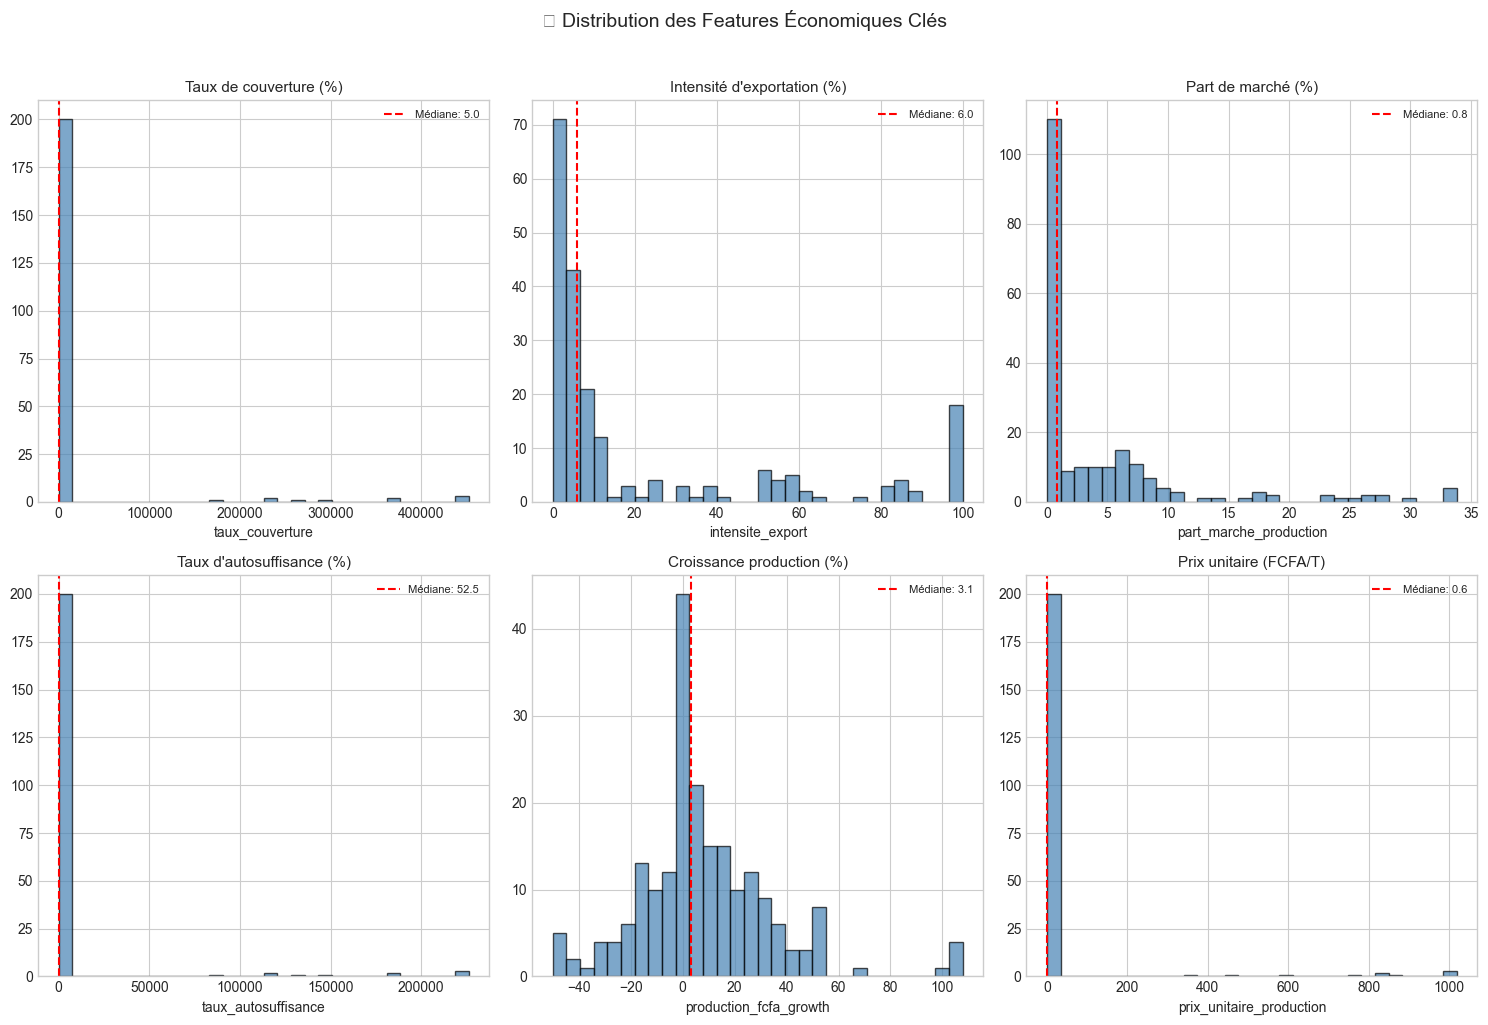

In [11]:
# Import paresseux de matplotlib/seaborn (utilisés uniquement pour cette visualisation)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# 9.1 Distribution des principales features économiques
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features_to_plot = [
    ('taux_couverture', 'Taux de couverture (%)'),
    ('intensite_export', "Intensité d'exportation (%)"),
    ('part_marche_production', 'Part de marché (%)'),
    ('taux_autosuffisance', "Taux d'autosuffisance (%)"),
    ('production_fcfa_growth', 'Croissance production (%)'),
    ('prix_unitaire_production', 'Prix unitaire (FCFA/T)')
]

for ax, (col, title) in zip(axes.flatten(), features_to_plot):
    data = df_ml[col].replace([np.inf, -np.inf], np.nan).dropna()
    # Limiter les valeurs extrêmes pour la visualisation
    q1, q99 = data.quantile([0.01, 0.99])
    data_clipped = data.clip(q1, q99)
    ax.hist(data_clipped, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(col)
    ax.axvline(data.median(), color='red', linestyle='--', label=f'Médiane: {data.median():.1f}')
    ax.legend(fontsize=8)

plt.suptitle('📊 Distribution des Features Économiques Clés', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [12]:
# Import paresseux de plotly (utilisé uniquement pour cette visualisation)
import plotly.graph_objects as go

# 9.2 Corrélation des nouvelles features avec la production
key_features = ['taux_couverture', 'intensite_export', 'ratio_prod_imports',
                'part_marche_production', 'taux_autosuffisance', 'production_fcfa_lag1',
                'production_fcfa_growth', 'production_fcfa_ma3', 'production_trend',
                'is_covid_period', 'years_since_start', 'sector_encoded']

# Calcul des corrélations avec la cible
correlations = df_ml[key_features + ['production_fcfa']].corr()['production_fcfa'].drop('production_fcfa')
correlations = correlations.sort_values(ascending=True)

# Visualisation
fig = go.Figure()
fig.add_trace(go.Bar(
    y=correlations.index,
    x=correlations.values,
    orientation='h',
    marker_color=['#e74c3c' if x < 0 else '#27ae60' for x in correlations.values]
))

fig.update_layout(
    title='🔗 Corrélation des Features avec la Production (FCFA)',
    xaxis_title='Coefficient de corrélation',
    yaxis_title='Feature',
    height=500
)
fig.show()

print("\n📊 Top 5 features les plus corrélées avec la production:")
for feat, corr in correlations.abs().sort_values(ascending=False).head(5).items():
    print(f"   - {feat}: {correlations[feat]:.3f}")


📊 Top 5 features les plus corrélées avec la production:
   - production_fcfa_ma3: 0.991
   - part_marche_production: 0.963
   - production_fcfa_lag1: 0.961
   - production_trend: 0.881
   - ratio_prod_imports: 0.687


## 10. 💾 Sauvegarde du dataset ML-ready

In [13]:
# Sauvegarde du dataset complet avec toutes les features
output_path = Path("../data/processed")

# Dataset complet
df_ml.to_csv(output_path / "dataset_ml_complete.csv", index=False)

# Sauvegarder aussi les encodeurs pour une utilisation future
import pickle

encoders = {
    'sector_encoder': label_encoder_sector,
    'period_encoder': label_encoder_period,
    'sector_mapping': sector_mapping,
    'period_mapping': period_mapping,
    'feature_columns': feature_cols
}

with open(output_path / "encoders.pkl", 'wb') as f:
    pickle.dump(encoders, f)

# Créer un fichier de métadonnées pour les features
feature_metadata = {
    'date_creation': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dimensions': df_ml.shape,
    'nb_features': len(feature_cols),
    'feature_categories': {k: [f for f in v if f in df_ml.columns] for k, v in feature_categories.items()},
    'target_options': target_options,
    'exclude_cols': exclude_cols,
    'all_columns': list(df_ml.columns)
}

with open(output_path / "feature_metadata.json", 'w', encoding='utf-8') as f:
    json.dump(feature_metadata, f, ensure_ascii=False, indent=2, default=str)

print("✅ Fichiers sauvegardés dans 'data/processed/':")
print(f"   📁 dataset_ml_complete.csv ({df_ml.shape[0]} × {df_ml.shape[1]})")
print(f"   📁 encoders.pkl (LabelEncoders + mappings)")
print(f"   📁 feature_metadata.json (métadonnées des features)")

✅ Fichiers sauvegardés dans 'data/processed/':
   📁 dataset_ml_complete.csv (210 × 52)
   📁 encoders.pkl (LabelEncoders + mappings)
   📁 feature_metadata.json (métadonnées des features)


## 11. 📝 Résumé et conclusions

In [14]:
# Résumé final
print("="*70)
print("📊 RÉSUMÉ DU FEATURE ENGINEERING")
print("="*70)

print(f"""
✅ DATASET ML-READY CRÉÉ AVEC SUCCÈS!

📐 Dimensions finales:
   • {df_ml.shape[0]} observations (21 secteurs × 10 années)
   • {df_ml.shape[1]} colonnes totales
   • {len(feature_cols)} features numériques pour le ML

📊 Catégories de features créées:

   🕐 Features temporelles (4):
      - year_normalized, years_since_start
      - is_covid_period, period_encoded
   
   💹 Ratios économiques (9):
      - Balance commerciale (FCFA & Tonnes)
      - Taux de couverture, Ratio prod/conso
      - Intensité d'export, Prix unitaires
   
   📈 Performance sectorielle (4):
      - Part de marché, Indice de spécialisation
      - Valeur ajoutée, Taux d'autosuffisance
   
   ⏮️ Features de lag (8):
      - Valeurs t-1 et t-2 pour 4 variables
   
   📊 Taux de croissance (4):
      - Croissance annuelle pour 4 variables
   
   📉 Moyennes mobiles (4):
      - MA3 pour 4 variables principales
   
   🏷️ Encodages (2):
      - sector_encoded, sector_size_encoded

🎯 Variables cibles potentielles:
   • production_fcfa (prédiction de production)
   • exports_fcfa (prédiction d'exportations)
   • balance_commerciale_fcfa (prédiction de balance)

📁 Fichiers générés:
   • dataset_ml_complete.csv
   • encoders.pkl
   • feature_metadata.json

🎯 Prêt pour le Notebook 3: Entraînement du modèle XGBoost!
""")
print("="*70)

📊 RÉSUMÉ DU FEATURE ENGINEERING

✅ DATASET ML-READY CRÉÉ AVEC SUCCÈS!

📐 Dimensions finales:
   • 210 observations (21 secteurs × 10 années)
   • 52 colonnes totales
   • 48 features numériques pour le ML

📊 Catégories de features créées:

   🕐 Features temporelles (4):
      - year_normalized, years_since_start
      - is_covid_period, period_encoded

   💹 Ratios économiques (9):
      - Balance commerciale (FCFA & Tonnes)
      - Taux de couverture, Ratio prod/conso
      - Intensité d'export, Prix unitaires

   📈 Performance sectorielle (4):
      - Part de marché, Indice de spécialisation
      - Valeur ajoutée, Taux d'autosuffisance

   ⏮️ Features de lag (8):
      - Valeurs t-1 et t-2 pour 4 variables

   📊 Taux de croissance (4):
      - Croissance annuelle pour 4 variables

   📉 Moyennes mobiles (4):
      - MA3 pour 4 variables principales

   🏷️ Encodages (2):
      - sector_encoded, sector_size_encoded

🎯 Variables cibles potentielles:
   • production_fcfa (prédiction de pr